In [1]:


from dataset import GlaucomaDataset
import torch
import timm
import torch.optim as optim
from torch import nn
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [18]:
root_dirs =  "G1020"
# lr = 1e-4
lr=0.0001
batch_size = 16
num_workers = 8
num_epochs = 50
max_images=None

In [19]:

dataset = GlaucomaDataset(root_dirs, 
                          split='train', max_images=max_images)

Successfully loaded train dataset with 1020 images.                                                  


In [20]:


# Suppose that `dataset` is your GlaucomaDataset instance
data_indices = list(range(len(dataset)))

# Perform the split
train_indices, test_indices = train_test_split(data_indices, test_size=0.2, random_state=42)
train_indices, val_indices = train_test_split(train_indices, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)
test_sampler = torch.utils.data.SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,  sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,  sampler=test_sampler)


In [21]:
print(len(dataset))
print(len(train_indices))
print(len(test_indices))
print(len(val_indices))


1020
612
204
204


In [22]:
# Use a pre-trained InceptionResNetV2 model
model = timm.create_model('inception_resnet_v2', pretrained=True , num_classes=2)

In [23]:
# Move the model to GPU if available
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device ='mps'
model = model.to(device)

In [24]:
# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


In [25]:
# Initialize lists for storing training and validation losses
train_losses = []
valid_losses = []

# Training loop
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        # Reshape the labels to match the output shape and convert to long datatype
        labels = labels.view(-1).long() 
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        # Print training progress
        if i % 10 == 9:  # Print every 10 batches
            print(f'Epoch {epoch+1}, Batch {i+1} loss: {running_loss/10:.3f}')
            running_loss = 0.0

    # Validation
    with torch.no_grad():
        val_loss = 0.0
        for i, data in enumerate(valid_loader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            # Reshape the labels to match the output shape and convert to long datatype
            labels = labels.view(-1).long()  
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            # Print validation progress
            if i % 10 == 9:  # Print every 10 batches
                print(f'Validation Epoch {epoch+1}, Batch {i+1} loss: {val_loss/10:.3f}')
                val_loss = 0.0

    avg_train_loss = running_loss / len(train_loader)
    avg_valid_loss = val_loss / len(valid_loader)
    print(f"Epoch {epoch + 1}, Training loss: {avg_train_loss}, Validation loss: {avg_valid_loss}")

    # Append the average losses for this epoch to our lists
    train_losses.append(avg_train_loss)
    valid_losses.append(avg_valid_loss)

print('Finished Training')

# Now you can use train_losses and valid_losses for your plots or save them to a file
# Save the trained model
torch.save(model.state_dict(), 'model_inceptionResnetV2.pth')


Epoch 1, Batch 10 loss: 0.689
Epoch 1, Batch 20 loss: 0.640
Epoch 1, Batch 30 loss: 0.583
Validation Epoch 1, Batch 10 loss: 0.631
Epoch 1, Training loss: 0.1357804299929203, Validation loss: 0.12641606881068304
Epoch 2, Batch 10 loss: 0.497
Epoch 2, Batch 20 loss: 0.476
Epoch 2, Batch 30 loss: 0.443
Validation Epoch 2, Batch 10 loss: 0.710
Epoch 2, Training loss: 0.11568926083735931, Validation loss: 0.21450134882560143
Epoch 3, Batch 10 loss: 0.252
Epoch 3, Batch 20 loss: 0.377
Epoch 3, Batch 30 loss: 0.356
Validation Epoch 3, Batch 10 loss: 0.835
Epoch 3, Training loss: 0.052201190820107095, Validation loss: 0.2272908091545105
Epoch 4, Batch 10 loss: 0.137
Epoch 4, Batch 20 loss: 0.104
Epoch 4, Batch 30 loss: 0.154
Validation Epoch 4, Batch 10 loss: 1.064
Epoch 4, Training loss: 0.069997794735126, Validation loss: 0.27202911560352033
Epoch 5, Batch 10 loss: 0.150
Epoch 5, Batch 20 loss: 0.181
Epoch 5, Batch 30 loss: 0.128
Validation Epoch 5, Batch 10 loss: 0.994
Epoch 5, Training lo

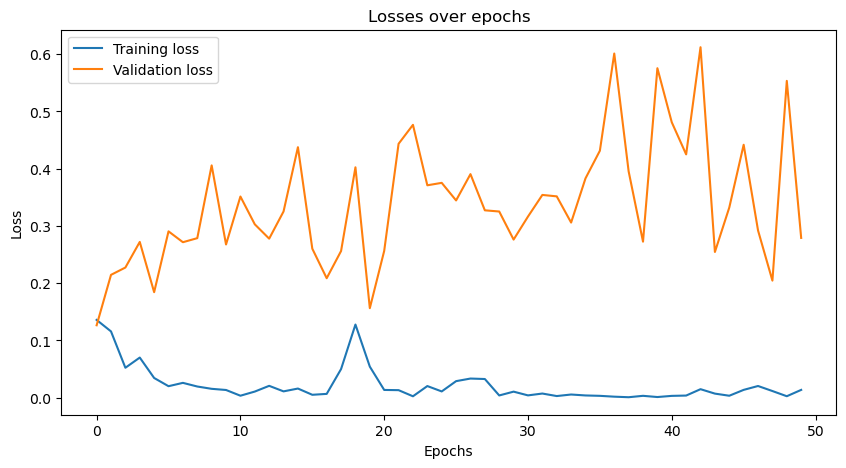

In [26]:


# assuming training_losses and validation_losses are your lists containing loss values

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Losses over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [27]:
# Model evaluation on test set
model.eval()
y_true = []
y_pred = []
for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    y_pred.extend(predicted.cpu().numpy().tolist())
    y_true.extend(labels.cpu().numpy().tolist())

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.69      0.81      0.74       143
           1       0.23      0.13      0.17        61

    accuracy                           0.61       204
   macro avg       0.46      0.47      0.46       204
weighted avg       0.55      0.61      0.57       204



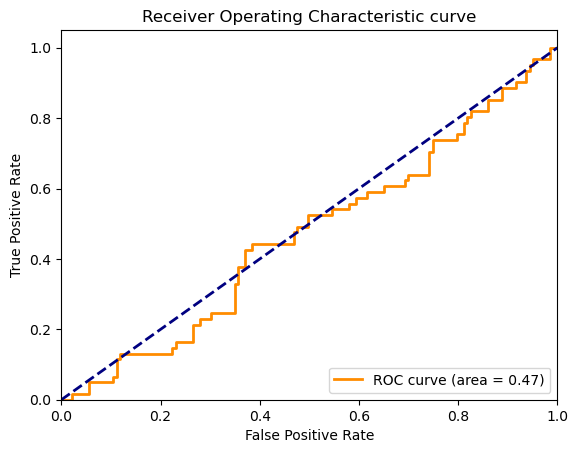

In [28]:



model.eval()

y_true = []
y_scores = []

for inputs, labels in test_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = torch.sigmoid(model(inputs)).detach().cpu().numpy()
    y_scores.extend(outputs[:, 1].tolist())  # Get the score for the positive class
    y_true.extend(labels.cpu().numpy().tolist())

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()


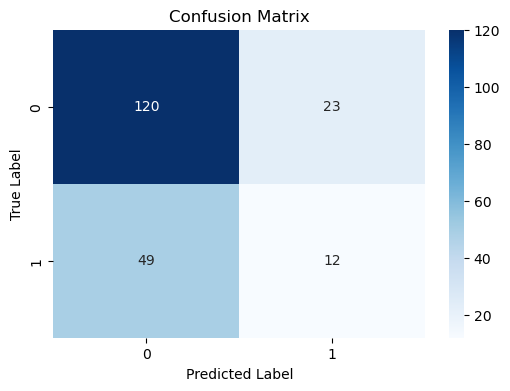

In [29]:


# Compute confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

# Visualize confusion matrix using seaborn heatmap
plt.figure(figsize=(6,4))
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
